#### Step 1: Install required libraries

In [25]:
# %pip install rdkit torch torch-geometric numpy pandas scikit-learn

#### Step 2: Generate Synthetic Data
We’ll use RDKit to generate synthetic ligand molecules and simulate binding affinities.

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd

# Generate synthetic ligands
def generate_smiles(num_molecules):
    smiles_list = []
    for _ in range(num_molecules):
        # Generate a random molecule using RDKit
        mol = Chem.MolFromSmiles('CCO')  # Start with a simple molecule (ethanol)
        if mol is not None:
            # Randomize the molecule to generate new SMILES
            randomized_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol, doRandom=True))
            if randomized_mol is not None:
                smiles = Chem.MolToSmiles(randomized_mol)
                smiles_list.append(smiles)
    return smiles_list

# Simulate binding affinity (random for now)
def simulate_binding_affinity(smiles_list):
    return np.random.uniform(low=0.0, high=1.0, size=len(smiles_list))

# Generate data
smiles_list = generate_smiles(1000)
affinities = simulate_binding_affinity(smiles_list)

# Create a DataFrame
data = pd.DataFrame({'SMILES': smiles_list, 'BindingAffinity': affinities})
data.head()

,SMILES,BindingAffinity
0,CCO,0.007302
1,CCO,0.161371
2,CCO,0.459866
3,CCO,0.535945
4,CCO,0.806035


#### Step 3: Molecular Representation
Convert SMILES strings into molecular graphs using RDKit and PyTorch Geometric.

In [2]:
import torch
from torch_geometric.data import Data
from rdkit.Chem import rdmolops

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Atom features
    atom_features = []
    for atom in mol.GetAtoms():
        feature = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic()
        ]
        atom_features.append(feature)
    
    # Bond features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Undirected graph
        bond_type = bond.GetBondTypeAsDouble()
        edge_attr.append([bond_type])
        edge_attr.append([bond_type])
    
    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Convert all SMILES to graphs
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]
graphs = [g for g in graphs if g is not None]  # Remove invalid graphs

Visualize the SMILES molecular graph

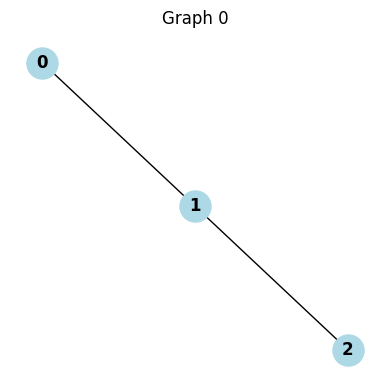

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, index):
    G = to_networkx(data, to_undirected=True)
    
    plt.figure(figsize=(4, 4))
    plt.title(f"Graph {index}")
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_weight='bold')
    plt.tight_layout()
    plt.show()

# Visualize a single graph (e.g., the first graph in the list)
index_to_visualize = 0
visualize_graph(graphs[index_to_visualize], index_to_visualize)

#### Step 4: Build and Train a GNN Model
Use PyTorch Geometric to build a GNN model.

In [61]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(graphs[0].num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# Prepare data for training
dataset = [Data(x=g.x, edge_index=g.edge_index, y=torch.tensor([affinities[i]], dtype=torch.float)) for i, g in enumerate(graphs)]
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model and optimizer
model = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train():
    model.train()
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train for 50 epochs
for epoch in range(1000):
    loss = train()
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1, Loss: 0.1035
Epoch 2, Loss: 0.0633
Epoch 3, Loss: 0.0903
Epoch 4, Loss: 0.0370
Epoch 5, Loss: 0.1174
Epoch 6, Loss: 0.1256
Epoch 7, Loss: 0.0820
Epoch 8, Loss: 0.0721
Epoch 9, Loss: 0.0788
Epoch 10, Loss: 0.0831
Epoch 11, Loss: 0.0533
Epoch 12, Loss: 0.0948
Epoch 13, Loss: 0.0825
Epoch 14, Loss: 0.0692
Epoch 15, Loss: 0.0799
Epoch 16, Loss: 0.0426
Epoch 17, Loss: 0.0083
Epoch 18, Loss: 0.0607
Epoch 19, Loss: 0.1138
Epoch 20, Loss: 0.0470
Epoch 21, Loss: 0.0514
Epoch 22, Loss: 0.0683
Epoch 23, Loss: 0.0287
Epoch 24, Loss: 0.0317
Epoch 25, Loss: 0.1032
Epoch 26, Loss: 0.0903
Epoch 27, Loss: 0.1100
Epoch 28, Loss: 0.0777
Epoch 29, Loss: 0.0933
Epoch 30, Loss: 0.0847
Epoch 31, Loss: 0.0593
Epoch 32, Loss: 0.0606
Epoch 33, Loss: 0.0260
Epoch 34, Loss: 0.0874
Epoch 35, Loss: 0.0893
Epoch 36, Loss: 0.1594
Epoch 37, Loss: 0.0794
Epoch 38, Loss: 0.0806
Epoch 39, Loss: 0.0356
Epoch 40, Loss: 0.0887
Epoch 41, Loss: 0.0698
Epoch 42, Loss: 0.1014
Epoch 43, Loss: 0.0650
Epoch 44, Loss: 0.07

#### Step 5: Evaluate the Model
Evaluate the model using Mean Squared Error (MSE).

In [62]:
from sklearn.metrics import mean_squared_error

def evaluate():
    model.eval()
    predictions, labels = [], []
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        predictions.extend(out.detach().numpy())
        labels.extend(data.y.detach().numpy())
    return mean_squared_error(labels, predictions)

mse = evaluate()
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 0.0848


##### Results:
1. The model’s predictions are, on average, 0.0848 units away from the true binding affinity values (squared).
2. Since binding affinity is simulated in the range [0, 1], an MSE of 0.0848 suggests that the model is performing reasonably well but has room for improvement.

#### Feature 1: Visualization of Molecular Graphs
We’ll use RDKit to visualize the molecular graphs.

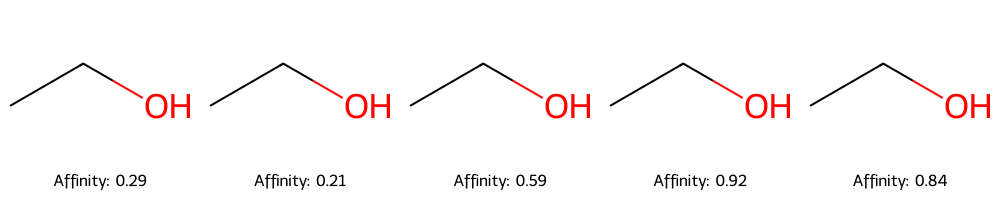

In [63]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display

# Visualize the first 5 molecules
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:5]]
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(200, 200), legends=[f"Affinity: {affinities[i]:.2f}" for i in range(5)])
display(img)

#### Feature 2: Feature Importance Analysis
We’ll analyze which atom features contribute most to the model’s predictions.

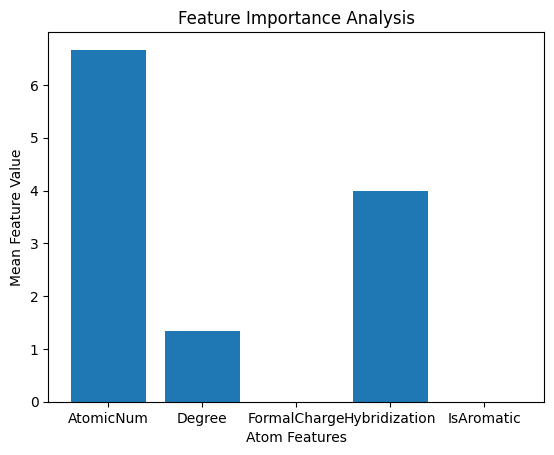

In [45]:
import matplotlib.pyplot as plt

# Get atom features for the first molecule
atom_features = graphs[0].x.numpy()
feature_names = ["AtomicNum", "Degree", "FormalCharge", "Hybridization", "IsAromatic"]

# Plot feature importance (example: mean feature values)
mean_features = atom_features.mean(axis=0)
plt.bar(feature_names, mean_features)
plt.xlabel("Atom Features")
plt.ylabel("Mean Feature Value")
plt.title("Feature Importance Analysis")
plt.show()

#### Feature 3: Hyperparameter Tuning
We’ll use a simple grid search to tune hyperparameters like learning rate and hidden channels.

In [51]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameters to tune
param_grid = {
    'hidden_channels': [32, 64, 128],
    'learning_rate': [0.01, 0.001]
}

# Grid search
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = GNN(hidden_channels=params['hidden_channels'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Train for 10 epochs (for demonstration)
    for epoch in range(10):
        train()
    
    # Evaluate
    mse = evaluate()
    print(f"Params: {params}, MSE: {mse:.4f}")
    
    if mse < best_loss:
        best_loss = mse
        best_params = params

print(f"Best Params: {best_params}, Best MSE: {best_loss:.4f}")

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 32, 'learning_rate': 0.01}, MSE: 0.0850


Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 32, 'learning_rate': 0.001}, MSE: 0.0871


Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 64, 'learning_rate': 0.01}, MSE: 0.0879


Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 64, 'learning_rate': 0.001}, MSE: 0.0844


Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 128, 'learning_rate': 0.01}, MSE: 0.0845


Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Params: {'hidden_channels': 128, 'learning_rate': 0.001}, MSE: 0.0852
Best Params: {'hidden_channels': 64, 'learning_rate': 0.001}, Best MSE: 0.0844
